<a href="https://colab.research.google.com/github/google/jax-md/blob/periodic_general_refactor/notebooks/meta_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [243]:
import taichi as ti
ti.init(random_seed=42, arch=ti.cpu, debug=True, advanced_optimization=False)

import IPython
import numpy as np
# Matplotlib settings.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim
# %matplotlib notebook
%matplotlib inline

[Taichi] Starting on arch=x64


## Optimization Through Dynamics

In [244]:
# ti helper funcs
dim=2
real = ti.f32
discrete = lambda: ti.field(dtype=real, shape=(1))
scalar = lambda **kwargs: ti.field(dtype=real,**kwargs)
vector = lambda **kwargs: ti.Vector.field(dim, dtype=real, **kwargs)

In [245]:
# init ti vars
ti.reset() # reset ti kernel to be allowed to init variables

dt = scalar(needs_grad=False)
steps = 100

height = 225
width_to_height_ratio = 16/9.
width = int(width_to_height_ratio * height)
dy = 1/height # difference is smaller of height, width

num_species = 4
particles_per_species = 120
N = num_species * particles_per_species
Ndim = N * dim

lr = 0.01

params_need_grad = True
# particle parameters
repelling_force = scalar(needs_grad=params_need_grad) # force active if r < separation radius
temperature = scalar(needs_grad=params_need_grad) # controls random fluctuations in particle velocities -> increases gradient variance
friction_coef = scalar(needs_grad=params_need_grad)  
separation_radius = scalar(needs_grad=params_need_grad) # mean separation radius
interaction_radius = scalar(needs_grad=params_need_grad) # mean interaction radius
force_strength = scalar(needs_grad=params_need_grad) # inter-particle force strength
close_range_factor = scalar(needs_grad=params_need_grad) # force strength multiplier at r=0
dist_range_factor = scalar(needs_grad=params_need_grad) # force strength multiplier at r=self.height
stdev = scalar(needs_grad=params_need_grad) # spread in species parameters -> increases gradient variance
seed_range = scalar(needs_grad=params_need_grad) # initial position spread

params = [
    dt,
    repelling_force,
    temperature,
    friction_coef,
    separation_radius,
    interaction_radius,
    force_strength,
    close_range_factor,
    dist_range_factor,
    stdev,
    seed_range
]
P = len(params)

array_needs_grad = True
species     = np.array([[spec]*particles_per_species for spec in range(num_species)]).reshape(-1)
force_radii = scalar(needs_grad=array_needs_grad)
separation_ = scalar(needs_grad=array_needs_grad)
intrprtcl_f = scalar(needs_grad=array_needs_grad)
repulsive_f = scalar(needs_grad=array_needs_grad)

# FIXME: I abuse ti.fields as N x 2 position/speed/force arrays. problem?
# also abuse them as adjacency matrix (Dxy)

# Game state:
R = vector(needs_grad=array_needs_grad)
V = vector(needs_grad=array_needs_grad)
F = vector(needs_grad=array_needs_grad)
Fupdated = vector(needs_grad=array_needs_grad)
Dxy = vector(needs_grad=array_needs_grad)

# loss
complexity = scalar(needs_grad=True)

arrays = {
    "force_radii": force_radii,
    "separation_": separation_,
    "intrprtcl_f": intrprtcl_f,
    "repulsive_f": repulsive_f,
    "R": R,
    "V": V,
    "F": F,
    "Fupdated": Fupdated,
    "Dxy": Dxy,
    "complexity": complexity
}

In [246]:
# initialization kernels
idx = lambda spec, prtcl: num_species * prtcl + spec

# deprecated:
# @ti.layout
# def place():
 
# neural network example:
# ti.root.dense(ti.ij, (n_actuators, n_sin_waves)).place(weights)
# ti.root.dense(ti.i, n_actuators).place(bias)

# place N x 2 vectors
# e.g. V = [steps, N] x 2
ti.root.dense(ti.l, steps).dense(ti.i, N).place(
    V, R, F, Fupdated
)
ti.root.dense(ti.ij, (N, N)).place(
    force_radii, separation_, intrprtcl_f, repulsive_f
)
ti.root.dense(ti.l, steps).dense(ti.ij, (N, N)).place(
    Dxy
)

# place scalars
ti.root.place(*(params + [complexity]))
ti.root.lazy_grad()

@ti.kernel
def set_ti_scalars():
    dt[None] = 0.01

    # set particle parameters
    repelling_force[None] = 4.0 # force active if r < separation_radius
    temperature[None] = 20.0 # controls random fluctuations in particle velocities -> increases gradient variance
    friction_coef[None] = 90.0  
    separation_radius[None] = 25.0 # mean separation radius
    interaction_radius[None] = 25.0 # mean interaction radius
    force_strength[None] = 10.0 # inter-particle force strength
    close_range_factor[None] = 2.0 # force strength multiplier at r=0
    dist_range_factor[None] = 2.0 # force strength multiplier at r=self.height
    stdev[None] = 0.05 # spread in species parameters -> increases gradient variance
    seed_range[None] = 0.9 # initial position spread
    
    complexity[None] = 0.0

@ti.func
def increment_vector_inplace(array_vector: ti.template(), magnitude: float, dy: float, dx: float):
    # increment array_vector (which is/may be row in an [? x 2]) vector field)
    theta = ti.atan2(dy, dx)
    array_vector[0] += magnitude * ti.cos(theta)
    array_vector[1] += magnitude * ti.sin(theta)
    
@ti.func
def force_init_loop(t, i: ti.i32):
    for j in range(N):
        increment_vector_inplace(F[t, i], intrprtcl_f[i, j], Dxy[t, i, j][0], Dxy[t, i, j][1])
        
@ti.kernel
def set_ti_vectors():
    # takes in R, V, F and updates them, t should be 0
    t: ti.i32 = 0
    for prtcl in range(N):
        half_seed = seed_range/2
        center_x = width/2
        center_y = height/2
        
        R[t, prtcl][0] = ti.random() * half_seed * width + center_x
        R[t, prtcl][1] = ti.random() * half_seed * height + center_y
        V[t, prtcl][0] = (ti.random() * 2 - 1)
        V[t, prtcl][1] = (ti.random() * 2 - 1)
    
        # update F
        force_init_loop(t, prtcl)
    
@ti.func
def particle_assignment_loop(spec_a, spec_b, fr, sep, f, rep):
    for prtcl_a in range(particles_per_species):
        for prtcl_b in range(particles_per_species):
            # assign
            force_radii[idx(spec_a, prtcl_a), idx(spec_b, prtcl_b)] = fr
            separation_[idx(spec_a, prtcl_a), idx(spec_b, prtcl_b)] = sep
            intrprtcl_f[idx(spec_a, prtcl_a), idx(spec_b, prtcl_b)] = f
            repulsive_f[idx(spec_a, prtcl_a), idx(spec_b, prtcl_b)] = rep
    
@ti.kernel
def set_block_matrices():
    # parameter matrices
    for spec_a in range(num_species):
        for spec_b in range(num_species):
            # sample once for this species pair direction
            fr = ti.abs((ti.randn() * stdev + 1) * interaction_radius)
            sep = ti.abs((ti.randn() * stdev + 1) * separation_radius)
            f = ti.randn() + force_strength
            rep_force = ti.abs((ti.randn() * stdev + 1) * repelling_force)
            
            particle_assignment_loop(spec_a, spec_b, fr_sep, f, rep)

In [247]:
# helper funcs

@ti.func
def wrap_borders(x: ti.template(), y: ti.template()):
    if x > width:
        x -= width
    elif x <= 0:
        x += width
    if y > width:
        y -= height
    elif y <= 0:
        y += height
    return x, y

@ti.func
def wrap_diffs(x: ti.template(), y: ti.template(), dx: ti.template(), dy:ti.template()):
    x_, y_ = x+dx, y+dy
    xnew, ynew = wrap_borders(x_, y_)
    dx, dy = xnew - x, ynew - y
    return dx, dy

@ti.kernel
def compute_complexity(t: ti.i32):
    # just macro temperature for now; FIXME make grid out of this
    # params R, V, F
    for prtcl in range(N):
        vx = V[t, prtcl][0]
        vy = V[t, prtcl][1]
        vsquare = vx * vx + vy * vy
        # ti.atomic_add(complexity, vsquare / Ndim)
        # ti.atomic_add(complexity,  vsquare / Ndim)
        complexity[None] += vsquare / Ndim

@ti.kernel
def apply_grad():
    # gradient descent on scalar parameters
    # params[i][None] -= lr * params[i].grad[None] # for loop doesnt seem to work
    repelling_force[None] += lr * repelling_force.grad[None]
    temperature[None] += lr * temperature.grad[None]
    friction_coef[None] += lr * friction_coef.grad[None]
    separation_radius[None] += lr * separation_radius.grad[None]
    interaction_radius[None] += lr * interaction_radius.grad[None]
    force_strength[None] += lr * force_strength.grad[None]
    close_range_factor[None] += lr * close_range_factor.grad[None]
    dist_range_factor[None] += lr * dist_range_factor.grad[None]
    stdev[None] += lr * stdev.grad[None]
    seed_range[None] += lr * seed_range.grad[None]

In [248]:
# physical kernels: attract, friction, update_system

@ti.kernel
def attract(t: ti.i32):
    # params F, R
    # updates Fupdated
    for a in range(N): # <-- gets vectorized <3
        for b in range(N): # <--- gets serialized :-(

            ra, rb = R[t-1, a], R[t-1, b]
            
            dx, dy = ra[0] - rb[0], ra[1] - rb[1]
    
            dx, dy = wrap_borders(dx, dy) # wrap borders
            
            Dxy[t, a, b][0] = dy
            Dxy[t, a, b][1] = dx

            xdoty = dx*dx + dy*dy
            dr = ti.sqrt(xdoty)
            inv_dr_2 = 1/(xdoty) # for each pair of particles, their euclidean distance


            f = close_range_factor * (inv_dr_2)
            # increase force at long range again
            f += (dist_range_factor - close_range_factor) * (dr * dy)
            f *= intrprtcl_f[a, b] # weight by randomly sampled interparticle force (depends on species)
            
            # add contributions from all particles b to entry a
            increment_vector_inplace(Fupdated[t, a], f, dy, dx)
            
@ti.kernel
def friction(t: ti.i32):
    # params V, R
    # updates Fupdated
    
    for prtcl in range(N):
        vx, vy = V[t, prtcl]
        v = ti.sqrt(vx * vx + vy * vy)
        theta = ti.atan2(vy, vx)

        # random doesnt seem to work in tape scope
        ffx = friction_coef[None] * v * ti.cos(theta) # + ti.randn() * temperature 
        ffy = friction_coef[None] * v * ti.sin(theta) # + ti.randn() * temperature

        Fupdated[t, prtcl][0] += ffx
        Fupdated[t, prtcl][0] += ffx

        
@ti.kernel
def update_system(t: ti.i32):
    # params R, V, Fupdated, dt
    # updates R, V, F

    # this loop gets vectorized:
    for prtcl in range(N):
        dx = V[t, prtcl][0] * dt
        dy = V[t, prtcl][1] * dt
        dx, dy = wrap_diffs(R[t, prtcl][0], R[t, prtcl][1], dx, dy)
        R[t, prtcl][0] += dx
        R[t, prtcl][1] += dy
        V[t, prtcl][0] -= Fupdated[t, prtcl][0] * dt
        V[t, prtcl][1] -= Fupdated[t, prtcl][1] * dt
        F[t, prtcl] = Fupdated[t, prtcl]

In [251]:
# main animate/forward functions that call into ti.kernels

DISPLAY = False
if DISPLAY:
    fig, ax = plt.subplots(figsize=(14,7)) #, facecolor="k")
    plt.title("Diff")
    plt.xlim([0, width])
    plt.ylim([0, height])
    particles = plt.scatter(
        np.zeros((N,)), np.zeros((N,)), 
        marker='.', c="b"
    )

def init_anim():
    particles.set_offsets([])
    return particles,

def step(t: ti.i32):
    # simulation
    attract(t)
    # friction(t)
    update_system(t)
    
    # display
    particles_display = np.zeros(shape=(N, dim), dtype=np.float32)
    for prtcl in range(N):
        particles_display[prtcl, 0] = R[t, prtcl][0]
        particles_display[prtcl, 1] = R[t, prtcl][1]
    if DISPLAY:
        particles.set_offsets(particles_display)
        print(f"{t} animated ...")
    else:
        plt.scatter(particles_display[:,0], particles_display[:,1], marker=".", c="b")
    
def run():
    # do simulation for many steps
    print(f"Simulating {steps} steps")
    if DISPLAY:
        animation = anim.FuncAnimation(
            fig, step, init_func=init_anim, blit=True
        )
    else:
        for t in range(steps):
            step(t)
    
def report():
    for i, p in enumerate(params):
        print(f"Param {i} grad: {p.grad.to_numpy().nonzero()}")
    for name, arr in arrays.items():
        print(f"{name}\t grad: {arr.grad.to_numpy().nonzero()}")
        print(f"{name}\t     : {arr}")
    print(f"Complexity: {complexity}")

# this function calls into the ti.kernels:
def forward():
    # within this context: update param.grad using autodiff
    with ti.Tape(complexity):
        # should these two setters be in tape scope? FIXME
        set_ti_scalars()
        set_ti_vectors()
        report()
        run() # simulate
        compute_complexity(steps-1) # set param.grad
    apply_grad() # gradient ascent update
    report()

Param 0 grad: (array([], dtype=int64),)
Param 1 grad: (array([], dtype=int64),)
Param 2 grad: (array([], dtype=int64),)
Param 3 grad: (array([], dtype=int64),)
Param 4 grad: (array([], dtype=int64),)
Param 5 grad: (array([], dtype=int64),)
Param 6 grad: (array([], dtype=int64),)
Param 7 grad: (array([], dtype=int64),)
Param 8 grad: (array([], dtype=int64),)
Param 9 grad: (array([], dtype=int64),)
Param 10 grad: (array([], dtype=int64),)
force_radii	 grad: (array([], dtype=int64), array([], dtype=int64))
force_radii	     : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
separation_	 grad: (array([], dtype=int64), array([], dtype=int64))
separation_	     : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
intrprtcl_f	 grad: (array([], dtype=int64), array([], dtype=int64))
intrp

<ipython-input-251-c17a9705a1c4>:48: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  print(f"Param {i} grad: {p.grad.to_numpy().nonzero()}")


Dxy	 grad: (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
Dxy	     : [[[[2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   ...
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]]

  [[2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   ...
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]]

  [[2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   ...
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]]

  ...

  [[2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   ...
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]
   [2.25000000e+02 4.00000000e+02]]

<ipython-input-251-c17a9705a1c4>:50: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  print(f"{name}\t grad: {arr.grad.to_numpy().nonzero()}")


RuntimeError: [ir.h:as@225] Assertion failure: is<T>()

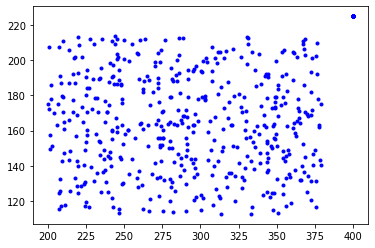

In [252]:
forward()

In [ ]:
"""
dt,
repelling_force,
temperature,
friction_coef,
separation_radius,
interaction_radius,
force_strength,
close_range_factor,
dist_range_factor,
stdev,
seed_range
"""

In [ ]:
arr = np.zeros(3)